# COBE Quadrilateralized Spherical Cube

This is a demonstration of my implementation of the COBE Quadrilateralized Spherical Cube (QSC) format. This was used to store all-sky astronomical data taken using the Comic microwave Background Explorer (COBE) satellite. Full details of the format can be found at https://lambda.gsfc.nasa.gov/product/cobe/skymap_info_new.cfm.



In [1]:
# import modules

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cobe import ecliptic_lat_lon_to_pix,raster_unfolded_pix,pix_to_ecliptic_lat_lon

The format decomposes a unit-sphere into six "faces", each having $4^{P-1}$ pixels. An example of how the pixels are spatially distributed for a $P=6$ sphere is given below:

Text(0.5, 0, '$z$')

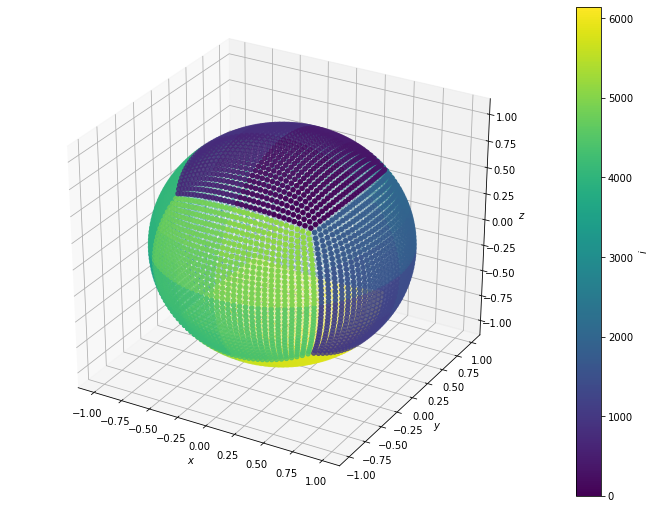

In [2]:
# make 3d plots
pix_index=6
indices=np.arange((4**(pix_index-1))*6)
e_lat,e_lon=pix_to_ecliptic_lat_lon(indices,pix_index)
x=np.cos(e_lat)*np.cos(e_lon)  
y=np.cos(e_lat)*np.sin(e_lon)
z=np.sin(e_lat)

fig=plt.figure(figsize=(12,9))
ax=fig.add_subplot(111, projection='3d')

# get plot viewing angles
ux=np.cos(ax.elev)*np.cos(ax.azim)  
uy=np.cos(ax.elev)*np.sin(ax.azim)
uz=np.sin(ax.elev)

# order points by viewing angle
order=np.argsort(-(ux*x+uy*y+uz*z))

# plot indices
im=ax.scatter(x[order],y[order],z[order],c=indices[order],cmap="viridis")
cbar=fig.colorbar(im,ax=ax)
cbar.set_label("$i$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

Note that for any given $P$, the pixel coordinate ia uniquely descibed by index $i$, where $0\leq i\leq6\times(P-1)-1$. The sequence of integers defines a hierarchical quadtree for each face. This is more apparent when we "unfold" the cube:

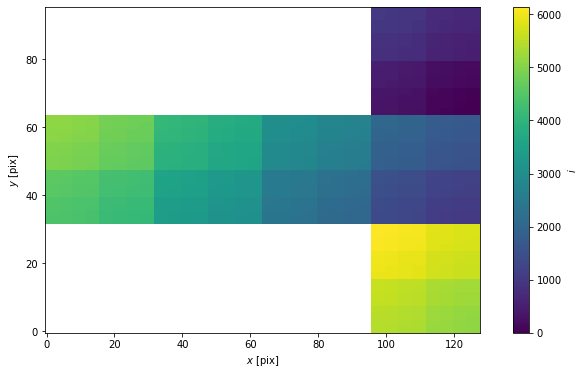

In [3]:
# make a map of indices
indices=raster_unfolded_pix(pix_index)

fig,ax=plt.subplots(1,1,figsize=(12,6))
im=ax.imshow(np.where(indices>-1,indices,np.nan),cmap="viridis",origin="lower")
ax.set_xlabel("$x$ [pix]")
ax.set_ylabel("$y$ [pix]")
cbar=fig.colorbar(im,ax=ax)
cbar.set_label("$i$")

## DRIBE

The Diffuse Infrared Background Experiment (DIRBE) on COBE mapped the sky at infrared wavelenghts. Here's an example where we gererate map projections from data stored in QSC format.

First, we load the data from a FITS file.

In [4]:
# load DIRBE data
dirbe_fits=fits.open("./DIRBE_BAND3A_ZSMA.FITS")
dirbe_brightness=dirbe_fits[1].data["Resid"]
pix_index=dirbe_fits[0].header["PIXRESOL"]

The QSC format assumes ecliptic coordinates. However, in this example it makes more sense to use galactic coordinates. We use astropy to perform the conversion.

In [5]:
# make galactic lat-lon values
n_lat=513
n_lon=1025
g_lat,g_lon=np.meshgrid(np.linspace(-0.5*np.pi,0.5*np.pi,n_lat),
                        np.linspace(-np.pi,np.pi,n_lon),indexing="ij")

In [6]:
# convert to ecliptic lat-lon values
gc=SkyCoord(b=g_lat*units.radian,l=g_lon*units.radian,frame="galactic")
e_lat=gc.geocentrictrueecliptic.lat.to("radian").value
e_lon=gc.geocentrictrueecliptic.lon.to("radian").value

## Projections

We can now generate projections of sky:

/home/odlomax/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


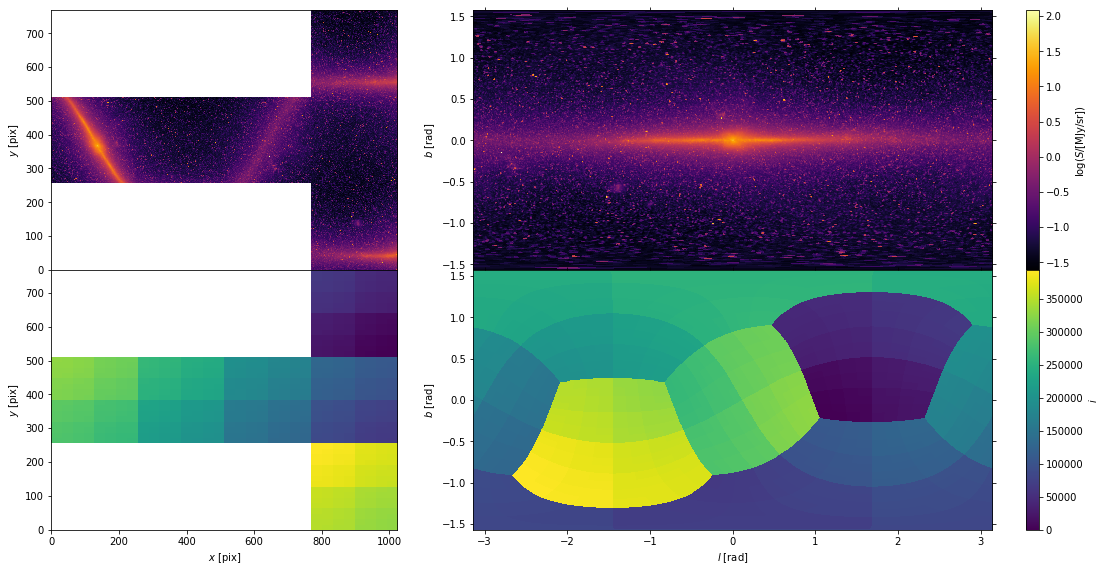

In [7]:
# make unfolded box projection
indices=raster_unfolded_pix(pix_index)
box_proj=np.full(indices.shape,np.nan)
box_proj[indices>-1]=dirbe_brightness[indices[indices>-1]]

# plot map
fig,ax=plt.subplots(2,2,figsize=(16,8))
im=ax[0,0].imshow(np.log10(box_proj),cmap="inferno",origin="lower")
ax[0,0].set_ylabel("$y$ [pix]")
ax[0,0].set_xticklabels([])

# plot indices
im=ax[1,0].imshow(np.where(indices>-1,indices,np.nan),cmap="viridis",origin="lower")
ax[1,0].set_xlabel("$x$ [pix]")
ax[1,0].set_ylabel("$y$ [pix]")

# make Mercator projection
indices=ecliptic_lat_lon_to_pix(e_lat,e_lon,pix_index)
mercator_proj=dirbe_brightness[indices]

#plot map
im=ax[0,1].imshow(np.log10(mercator_proj),extent=(g_lon[0,0],g_lon[0,-1],g_lat[0,0],g_lat[-1,0]),cmap="inferno",origin="lower")
cbar=fig.colorbar(im,ax=ax[0,1])
cbar.set_label("log($S$/[MJy/sr])")
ax[0,1].tick_params(top=True,left=True,bottom=True,right=True)
ax[0,1].set_ylabel("$b$ [rad]")
ax[0,1].set_xticklabels([])

# plot indices
im=ax[1,1].imshow(indices,extent=(g_lon[0,0],g_lon[0,-1],g_lat[0,0],g_lat[-1,0]),cmap="viridis",origin="lower")
cbar=fig.colorbar(im,ax=ax[1,1])
cbar.set_label("$i$")
ax[1,1].tick_params(top=True,left=True,bottom=True,right=True)
ax[1,1].set_xlabel("$l$ [rad]")
ax[1,1].set_ylabel("$b$ [rad]")
fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=-0.15,left=-0.0725,right=1.0)

Left: an unfolded box projection of the sky, measured with DIRBE at $3.5\,\mathrm{\mu m}$. Right: a Mercator projection in galactic coordinates $(b,l)$ of the same data. In both figures, the top frame shows the $3.5\,\mathrm{\mu m}$ surface brightness; the bottom frame shows the location $i$ of the surface brightness value in the pixel vector.